# CookieCutter
This app predicts the total calories given a string of recipe ingredients.

Training data was scraped from AllRecipes.com

## Import packages

In [3]:
import numpy as np
import pandas as pd
import re

## Import functions

In [4]:
def multireplace(string, replacements, ignore_case=False):
    """
    Given a string and a replacement map, it returns the replaced string.
    :param str string: string to execute replacements on
    :param dict replacements: replacement dictionary {value to find: value to replace}
    :param bool ignore_case: whether the match should be case insensitive
    :rtype: str
    """
    # If case insensitive, we need to normalize the old string so that later a replacement
    # can be found. For instance with {"HEY": "lol"} we should match and find a replacement for "hey",
    # "HEY", "hEy", etc.
    if ignore_case:
        def normalize_old(s):
            return s.lower()

        re_mode = re.IGNORECASE

    else:
        def normalize_old(s):
            return s

        re_mode = 0

    replacements = {normalize_old(key): val for key, val in replacements.items()}
    
    # Place longer ones first to keep shorter substrings from matching where the longer ones should take place
    # For instance given the replacements {'ab': 'AB', 'abc': 'ABC'} against the string 'hey abc', it should produce
    # 'hey ABC' and not 'hey ABc'
    rep_sorted = sorted(replacements, key=len, reverse=True)
    rep_escaped = map(re.escape, rep_sorted)
    
    # Create a big OR regex that matches any of the substrings to replace
    pattern = re.compile("|".join(rep_escaped), re_mode)
    
    # For each match, look up the new string in the replacements, being the key the normalized old string
    return pattern.sub(lambda match: replacements[normalize_old(match.group(0))], string)

def string_replace(x):
    new_string = re.sub(' {2,}', ' ', x).replace("\n", ";").replace("; ;", ";")
#    new_string = new_string.split(';')
    return(new_string)

def get_ingredients (x):
    ing_regex = ('(\d+/*\d*\s*\d*/*\d*)\s(\w+\s*.*?);')
    all_ing = re.findall(ing_regex, x)
    return(all_ing)

def get_quantity(x):
    quantity = [y[0] for y in x] # use for df
    units_with_ingredient = [y[1] for y in x]
    df_of_units = pd.DataFrame({'ingredient':units_with_ingredient, 'quantity':quantity})
    return (df_of_units)

def match_uids(originaldf, longdf):
    for row in range(0, len(originaldf)):
        longdf[row]['recipe_key']=originaldf['recipe_key'][row]
        longdf[row]['calPerServing']=originaldf['calPerServing'][row]
        longdf[row]['totalCal']=originaldf['totalCal'][row]
        longdf[row]['num_ingredients']=originaldf['num_ingredients'][row]
        longdf[row]['servings']=originaldf['servings'][row]
        longdf[row]['name']=originaldf['name'][row]
    return(longdf)

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    import string
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    wnl = WordNetLemmatizer()
    
    def lemmatize(string):
        for word in re.findall(r"[a-z]+", string):
            string = string.replace(word, wnl.lemmatize(word, 'n') if 's' in word[-3:] else word)
        return string
    
    unit_stopwords = ['dash','pinch','teaspoon','tablespoon','fluid','cup','pint','quart','ounce','oz','pound','rack',
                'small','medium','large','crushed','grated','skinless','boneless','melted','fresh',
                'diced','minced','thinly','dry','dried','halved','taste','frying','lean','drained','jars','grated'
                'clove','slice','eaches','whole','cube','thick','unit','freshly','finely','splash',
                'semisweet','chip','extract','spread','powder','room','temperature','brown','cooking','yolk','ground',
                'package','mix','cake','plain','goody','light','wheat','piece','substitute','mini','kosher','crispy',
                'minature','chunk','dark','bit','square','boiling','bag','crumb','popsicle','stick','zest','cereal',
                'bar','tart','nib','tennessee','turbinado','baking','pack','spice','moist','miniarature','crunchy',
                'morsel','nugget','candy','crisp','super','fine','decoration','sucralose','puree','pureed','rainbow',
                'cut','frozen','broken','round','concentrate','miniature','cooky','virgin','dusting','half','baby',
                'food','jar','seedless','container','box','granule','filling','cold','super','ripe','moisture',
                'packet','instant','mint','ripe','sea','coarse','fun','size','funsize','bulk','chopped','torn']
    
    # Remove anything in parenthesis
    mess = re.sub(r"\([^\)]+\)", '', mess)
    # Make everything lowercase
    mess = mess.lower()
    # Remove non-word punctuation
    mess =' '.join(re.findall(r"[-,''\w]+", mess)) # This leaves some commas as a character #
    mess = re.sub(r"\,", ' ', mess)
    # Remove hypenated words
    mess = re.sub(r"(?=\S*['-])([a-zA-Z'-]+)",'',mess) # remove hypenated words
    # Remove punctuation and numbers
    mess = ''.join([i for i in mess if not i.isdigit()])
    # Remove plurals
    mess = lemmatize(mess)
    #clean excess whitespace
    mess = re.sub(r"\s+", ' ', mess).strip()
    # Remove stopwords
    mess = [word for word in mess.split() if word.lower() not in stopwords.words('english')]
    mess  = [word for word in mess if word.lower() not in unit_stopwords]
    mess = ' '.join(mess)
    return(mess.split())

def test_noun(tokens):  
    import nltk
    tagged = nltk.pos_tag(tokens)
    return([token[0] for token in tagged if token[1] in ['NN',]])

def convert_fractions (quantity):
    from fractions import Fraction
    return float(sum(Fraction(s) for s in quantity.split()))

def join_strings(mess):
    # Keep integers
    mess = ' '.join(mess)

    if len(mess)>=1:
        return(mess)
    else:
        return('')

## Clean ingredient text string

In [11]:
# Load data
#df = pd.read_csv('dataset_allrecipes-test-v3_2020-06-02_01-37-25-797.csv') # Dinner recipes
df = pd.read_csv('dataset_allrecipes-test-v4_choco_chip_cookie_2020-06-06_22-41-30-703.csv') # Chocolate chip recipes

# df = pd.read_csv('dataset_allrecipes-test-v4_all-cookies_2020-06-06_22-20-57-219.csv') # all cookie recipes
# df2 = pd.read_csv('dataset_allrecipes-test-v4_all-ingredients_2020-06-06_22-40-04-991.csv') # all ingredient recipes
# df = pd.concat([df,df2]).drop_duplicates() # combine all cookie and ingredient recipes

# Clean column names
df.rename(columns = {'calories':'calPerServing', 'cook':'cookTime', 'prep':'prepTime','ready in':'totalTime'}, inplace = True) 

# Create unique id
df['recipe_key'] = df['url'].apply(lambda x:int(re.findall(r"\d+", x)[0]))

# Keep recipes that have between 12 and 64 servings
df = df[(df['servings']<=64) & (df['servings']>=12)]
# Calculate total calories per recipe
df['totalCal'] = df['calPerServing']*df['servings']

# Remove null values and reset index
#df.dropna(axis=0, how='any',inplace=True)  # drop recipes missing cooking times
df.reset_index(inplace=True, drop=True)

# Clean ingredient text
dict_unicode = {'\u2009': '', '½':' 1/2', '⅓':'1/3', '⅔':'2/3', '¼':'1/4', '¾':'3/4', '⅕':'1/5', 
                '⅖':'2/5', '⅗':'3/5', '⅘':'4/5', '⅙':'1/6', '⅚':'5/6', '⅐':'1/7', '⅛':'1/8', 
                '⅜':'3/8', '⅝':'5/8', '⅞':'7/8', '⅑':'1/9', '⅒':'1/10'}
df['recipeIngredient'] = [item + ';' for item in df['recipeIngredient']] # add semicolon at end of each string for easier regex filtering
df['recipeIngredient'] = [multireplace(x, dict_unicode) for x in df['recipeIngredient']] # replace unicode characters
df['recipeIngredient'] = [string_replace(x) for x in df['recipeIngredient']] # remove whitespace
ing = [get_ingredients(x) for x in df['recipeIngredient']] # separate ingredients into list of list of tupules of ingredient strings
df['num_ingredients'] = [len(x) for x in ing] # count number of ingredients per recipe

df_ing = [get_quantity(x) for x in ing] # separate units of measure and ingredients & creates a pandas dataframe for each recipe

clean_df = match_uids(df, df_ing) # pull unique id, calorie (outcome variable), number of servings, and number of ingredients from original dataframe
clean_df = pd.concat(clean_df) # concat list of pandas dataframes into one dataframe
clean_df['quantity'] = [convert_fractions(x) for x in clean_df['quantity']] # convert fractions into integers

# Create multiIndex / hierarchical Dataframe
# clean_df = clean_df.reset_index(drop=True)
clean_df = clean_df.reset_index()


In [622]:
# # Create multiIndex / hierarchical Dataframe
# clean_df = clean_df.reset_index()
# arrays = [clean_df['recipe_key'],clean_df['index']]
# tuples = list(zip(*arrays))
# index = pd.MultiIndex.from_tuples(tuples, names=['recipe_key', 'ingredient_key'])
# clean_df.set_index(index,inplace=True)
# #clean_df['ingredient'].replace('',clean_df['unit'],inplace=True)
# clean_df.drop('index', axis=1, inplace=True)

## Normalize quantity of ingredients to grams

In [12]:
# save as csv for web app
# clean_df.to_csv('clean_df.csv')

# # Convert measurements to normalized unit  (1 Unit= 1/3 grams)
# clean_df['unit'] = np.where(clean_df.ingredient.str.contains("dash"), 1,
#             np.where(clean_df.ingredient.str.contains("pinch"), 2,
#             np.where(clean_df.ingredient.str.contains("teaspoon"), 15, 
#             np.where(clean_df.ingredient.str.contains("tablespoon"), 45,
#             np.where(clean_df.ingredient.str.contains("fluid"), 90,
#             np.where(clean_df.ingredient.str.contains("cup"), 720, 
#             np.where(clean_df.ingredient.str.contains("pint"), 1419,
#             np.where(clean_df.ingredient.str.contains("quart"), 2850,
#             np.where(clean_df.ingredient.str.contains("ounce"), 84,
#             np.where(clean_df.ingredient.str.contains("oz"), 84, 
#             np.where(clean_df.ingredient.str.contains("pound"), 1362,
#             np.where(clean_df.ingredient.str.contains("rack"), 2724,
#             np.where(clean_df.ingredient.str.contains("small"), 150,
#             np.where(clean_df.ingredient.str.contains("medium"), 180,
#             np.where(clean_df.ingredient.str.contains("large"), 210,
#             3))))))))))))))) 

# Convert measurements to normalized unit  (1 Unit= 1 grams)
clean_df['unit'] = np.where(clean_df.ingredient.str.contains("dash"), .3,
            np.where(clean_df.ingredient.str.contains("pinch"), .6,
            np.where(clean_df.ingredient.str.contains("teaspoon"), 5, 
            np.where(clean_df.ingredient.str.contains("tablespoon"), 3,
            np.where(clean_df.ingredient.str.contains("fluid"), 30,
            np.where(clean_df.ingredient.str.contains("cup"), 240, 
            np.where(clean_df.ingredient.str.contains("pint"), 473,
            np.where(clean_df.ingredient.str.contains("quart"), 980,
            np.where(clean_df.ingredient.str.contains("ounce"), 28,
            np.where(clean_df.ingredient.str.contains("oz"), 28, 
            np.where(clean_df.ingredient.str.contains("pound"), 454,
            np.where(clean_df.ingredient.str.contains("rack"), 908,
            np.where(clean_df.ingredient.str.contains("small"), 50,
            np.where(clean_df.ingredient.str.contains("medium"), 60,
            np.where(clean_df.ingredient.str.contains("large"), 70,
            3))))))))))))))) 

## Tokenize ingredient text

In [15]:
# Tokenization = convert text string into list of tokens, or words, we want (i.e., cleaned version of words).
import string
from nltk.corpus import stopwords
clean_df['ingredient']=[text_process(x) for x in clean_df['ingredient']]

# thresh = 600; # Dinner recipe calorie threshold; mean = 500, median = 463, 75%quartile = 600
thresh = 6000; # 250 calores for 24 cookies
df['label'] = [1 if a_ > thresh else 0 for a_ in df['calPerServing']]
clean_df['label'] = [1 if a_ > thresh else 0 for a_ in clean_df['calPerServing']]

# Total quantity of each ingredient needed for recipe (grams* quantity) and condense into a list.
clean_df['norm_quant'] = round(clean_df['unit']*clean_df['quantity'])
clean_df['norm_quant'] = clean_df['norm_quant'].astype(int)

# One word per ingredient - keep only nouns, join multiple words as one string
clean_df['ingredient'] = [test_noun(tokens) for tokens in clean_df['ingredient']]
clean_df['ingredient'] = [''.join(tokens) for tokens in clean_df['ingredient']]

# Repeat word by normalized quantity
clean_df['ingredient'] = clean_df['ingredient'].astype(str) + ' '
zipped = list(zip(clean_df['ingredient'], clean_df['norm_quant']))
output = [t[0]*t[1] for t in zipped]
final_df = pd.DataFrame(output, columns=['ingredient'])
final_df[['recipe_key','totalCal','calPerServing','name','label','ingredient_key']] = clean_df[['recipe_key','totalCal','calPerServing','name','label','index']]

# Create multiIndex / hierarchical Dataframe
tuples = list(zip(*[final_df['recipe_key'],final_df['ingredient_key']]))
index = pd.MultiIndex.from_tuples(tuples, names=['recipe_key', 'ingredient_key'])
final_df.set_index(index,inplace=True)
final_df.head()

ingredient  \
recipe_key ingredient_key                                                      
11061      0               flour flour flour flour flour flour flour flou...   
           1                                            soda soda soda soda    
           2               sugar sugar sugar sugar sugar sugar sugar suga...   
           3               chocolate chocolate chocolate chocolate chocol...   
           4               sugar sugar sugar sugar sugar sugar sugar suga...   

                           recipe_key  totalCal  calPerServing  \
recipe_key ingredient_key                                        
11061      0                    11061      3168            264   
           1                    11061      3168            264   
           2                    11061      3168            264   
           3                    11061      3168            264   
           4                    11061      3168            264   

                                                                        name  \
recipe_key ingredient_key                                                      
11061      0               Julia's Best Ever Chocolate Chip Cookies In A Jar   
           1               Julia's Best Ever Chocolate Chip Cookies In A Jar   
           2               Julia's Best Ever Chocolate Chip Cookies In A Jar   
           3               Julia's Best Ever Chocolate Chip Cookies In A Jar   
           4               Julia's Best Ever Chocolate Chip Cookies In A Jar   

                           label  ingredient_key  
recipe_key ingredient_key                         
11061      0                   0               0  
           1                   0               1  
           2                   0               2  
           3                   0               3  
           4                   0               4

In [689]:
clean_df.head()

,index,ingredient,quantity,recipe_key,calPerServing,totalCal,num_ingredients,servings,name,unit,label,norm_quant
0,0,butter,0.75,16212,162.0,6480.0,9,40,Chocolate Mint Candies Cookies,240.0,0,180
1,1,sugar,1.50,16212,162.0,6480.0,9,40,Chocolate Mint Candies Cookies,240.0,0,360
2,2,water,2.00,16212,162.0,6480.0,9,40,Chocolate Mint Candies Cookies,3.0,0,6
3,3,chocolate,2.00,16212,162.0,6480.0,9,40,Chocolate Mint Candies Cookies,240.0,0,480
4,4,egg,2.00,16212,162.0,6480.0,9,40,Chocolate Mint Candies Cookies,3.0,0,6


In [ ]:
# Test data using ngrams to identify words (ie. baking soda)
from nltk import ngrams

bigram = [list(ngrams(words.lower().split(),2)) for words in clean_df['ingredient']]
# trigram=list(ngrams(Sentences.lower().split(),3))
# fourgram=list(ngrams(Sentences.lower().split(),4))

In [732]:
df[df['key']==9605]

,calPerServing,carbohydratesg,cholesterolmg,cookTime,directions,ingredients,name,nutrition,prepTime,proteing,...,recipeDirection,recipeIngredient,servings,sodiummg,totalFatg,url,key,totalCal,num_ingredients,label
96,279,279 calories; 15.4 g total fat; ...,19,NaN,1. Preheat oven to 350 degrees F. 2. Melt butt...,"½ cup butter, 1 ½ cups graham cracker crumbs, ...",Peanut Butter/Chocolate Chip Cookie Bars,279 calories; 15.4 g total fat; ...,NaN,15.4,...,Preheat oven to 350 degrees F.\n ...,1/2 cup butter; 1 1/2 cups graham cracker cru...,20,279 calories; 15.4 g total fat; ...,279 calories; 15.4 g total fat; ...,https://www.allrecipes.com/recipe/9605/peanut-...,9605,5580,5,1


In [247]:
clean_df.loc[9605]

,ingredient,quantity,key,calPerServing,totalCal,num_ingredients,servings,name,unit,label,norm_quant
ingredient_key,,,,,,,,,,,
0,butter,0.5,9605,279.0,5580.0,5,20,Peanut Butter/Chocolate Chip Cookie Bars,720,1,360
1,grahamcracker,1.5,9605,279.0,5580.0,5,20,Peanut Butter/Chocolate Chip Cookie Bars,720,1,1080
2,milk,14.0,9605,279.0,5580.0,5,20,Peanut Butter/Chocolate Chip Cookie Bars,84,1,1176
3,chocolate,2.0,9605,279.0,5580.0,5,20,Peanut Butter/Chocolate Chip Cookie Bars,720,1,1440
4,peanutbutter,1.0,9605,279.0,5580.0,5,20,Peanut Butter/Chocolate Chip Cookie Bars,720,1,720


# NLP
1) Bag of words

2) TF-IDF (term frequency-inverse document frequency)

3) Combine word weights (from TF-IDF) with quantitative metrics (quantity, serving size), then model based on that

4) Train test split

5) Machine learning model


In [16]:
df.rename(columns = {'recipe_key':'key'}, inplace = True) 
final_df.rename(columns = {'recipe_key':'key'}, inplace = True) 
X_ing = final_df.groupby('recipe_key')['ingredient'].apply(' '.join) # join list of strings into one string per recipe
X_ing = pd.DataFrame(X_ing)
X_ing[['orig_ing','name']] = df.set_index('key')[['recipeIngredient','name']]

y_cal = df.set_index('key')[['totalCal','calPerServing','name','label']].sort_index().copy()

y_label = df.set_index('key')['label']
X_keys = df.reset_index(drop=True)['key']

from sklearn.model_selection import train_test_split # Train Test Split
key_train, key_test, y_train, y_test = train_test_split(X_keys, y_label, test_size=0.2, random_state=101) # won't work with multilevel index

X_train = X_ing.loc[key_train]
X_test = X_ing.loc[key_test]
y_cal_train = y_cal.loc[key_train]
y_cal_test = y_cal.loc[key_test]

X_train.sort_index(inplace=True)
X_test.sort_index(inplace=True)
y_train.sort_index(inplace=True)
y_test.sort_index(inplace=True)
y_cal_train.sort_index(inplace=True)
y_cal_test.sort_index(inplace=True)

print("Training set contains {} recipes in total".format(len(key_train)))
print("Test set contains {} recipes in total".format(len(key_test)))

Training set contains 294 recipes in total
Test set contains 74 recipes in total


In [690]:
# Save data as csv
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')
y_cal_train.to_csv('y_cal_train.csv')
y_cal_test.reset_index().to_csv('y_cal_test.csv')

# NLP - separate steps
#### Bag of words vectorization

In [17]:
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
bow_transformer = CountVectorizer(analyzer=text_process).fit(X_train['ingredient'])
print(len(bow_transformer.vocabulary_)) # Print total number of vocab words
print(bow_transformer.get_feature_names()) # Print all words

ingredient_bow = bow_transformer.transform(X_train['ingredient'])

148
['almond', 'almondbutter', 'almondflour', 'almondmilk', 'applesauce', 'avocado', 'bacon', 'banana', 'barley', 'bean', 'bittersweetchocolate', 'blackstrap', 'blueberry', 'blueberryjam', 'bourbon', 'brandy', 'buckwheatflour', 'butter', 'buttermargarine', 'buttermilk', 'butterscotch', 'butterscotchpudding', 'canesugar', 'canolaoil', 'caramel', 'carameldessert', 'cardamom', 'cherry', 'chestnut', 'chickpea', 'chili', 'chocolate', 'chocolatefudge', 'chocolatehard', 'chocolatepeanutbutter', 'chocolatesyrup', 'chocolatetoffee', 'cinnamon', 'clove', 'cocoa', 'coconut', 'coconutflour', 'coconutoil', 'coconutpalmsugar', 'coconutsugar', 'coffee', 'coffeeliqueur', 'cookie', 'cornflake', 'cornstarch', 'cornsyrup', 'cranberry', 'cream', 'creamcheese', 'creamtartar', 'cremeliqueur', 'dropgreen', 'droplemonjuice', 'dropmaple', 'egg', 'espresso', 'fig', 'flake', 'flaxseedmeal', 'flour', 'gallonvanillaicecream', 'germ', 'ginger', 'grahamcracker', 'granola', 'granolanutraisin', 'grapeseedoil', 'hachiy

In [ ]:
# Sparse matrix[ingredient_name,recipe]
print(ingredient_bow[:,1])

In [673]:
X_train.head()

,ingredient,orig_ing,name
recipe_key,,,
6686,flour flour flour flour flour flour flour flou...,2 cups whole wheat flour; 1/4 cup wheat germ; ...,Banana Wheat Bread
6696,water water water water water water water wate...,"3/4 cup warm water; 1 egg, lightly beaten; 1 t...",Cinnamon Cranraisin Bread
6698,flour flour flour flour flour flour flour flou...,3 cups all-purpose flour; 1 teaspoon salt; 1 t...,Mom's Zucchini Bread
6714,flour flour flour flour flour flour flour flou...,1 1/2 cups unbleached all-purpose flour; 1 cup...,Banana Oat Muffins
6730,egg egg egg egg egg egg egg egg egg sugar sug...,3 eggs; 2 cups white sugar; 1 cup vegetable oi...,Chocolate Chip Orange Zucchini Bread


In [679]:
# Example bag of words on one recipe
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
bow0 = bow_transformer.transform([X_train['ingredient'].loc[6686]])
print(bow0) # tells us what words appear and the frequency
print('\n')
print(bow_transformer.get_feature_names()[145]) # This tells us what the word is for a given index

  (0, 38)	360
  (0, 266)	6
  (0, 286)	480
  (0, 301)	60
  (0, 334)	120
  (0, 432)	60
  (0, 542)	5
  (0, 562)	5
  (0, 631)	5


chocolatealmond


In [681]:
# Bag of word counts are saved in a sparse matrix which compresses the information to save computer memory
print('Shape of Sparse Matrix: ', ingredient_bow.shape) # matrix size (number of recipes, total number of words)
print('Amount of Non-Zero occurences: ', ingredient_bow.nnz) 
sparsity = (100.0 * ingredient_bow.nnz / (ingredient_bow.shape[0] * ingredient_bow.shape[1]))
print('sparsity: {}'.format(sparsity)) # total number of words / (number of recipes * total number of words)*100% compares non-zero words versus total number of words

Shape of Sparse Matrix:  (2380, 667)
Amount of Non-Zero occurences:  19014
sparsity: 1.197762463306162


#### TF-IDF (term frequency-inverse document frequency)

In [21]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(ingredient_bow) # weight of words over whole document

# Example TF-IDF on one recipe
# tfidf0 = tfidf_transformer.transform(bow0)
# print(tfidf0)

# Transform the entire bag-of-words corpus into TF-IDF corpus at once:
ingredient_tfidf = tfidf_transformer.transform(ingredient_bow)
print(ingredient_tfidf.shape)

(294, 148)


In [686]:
# To see document frequency of a specific word
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['almond']])

3.712680813459896


#### Train & test model

In [ ]:
from sklearn.naive_bayes import MultinomialNB # Naive Bayes Model
recipe_model = MultinomialNB().fit(ingredient_tfidf, y_train)

In [ ]:
predictions = recipe_model.predict(ingredient_tfidf)

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(predictions,y_train))

### Save ML model using pickle

In [22]:
# Save pickle files
import pickle
pickle.dump(bow_transformer,open('bow_transformer.sav','wb'))
pickle.dump(ingredient_bow,open('ingredient_bow.sav','wb'))
pickle.dump(ingredient_tfidf,open('ingredient_tfidf.sav','wb'))

In [25]:
# Load pickle files
import pickle
bow_transformer = pickle.load(open('bow_transformer.sav','rb'))
ingredient_bow_train = pickle.load(open('ingredient_bow.sav','rb'))
ingredient_bow_test = bow_transformer.transform(X_test['ingredient'])

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(ingredient_bow_train,y_cal_train['totalCal'])

predictions = linreg.predict(ingredient_bow_test)
predictions

array([ 4932.693411  ,  6438.15140553,  7292.38917621, 12372.98747874,
        5416.63048475,  4358.90817459,  4263.86349625,  5253.11268489,
        3798.56349965,  8104.01771381,  5907.57148953,  5034.3511828 ,
        4764.30137824,  5464.14835521,  7014.29576656, 11466.32801282,
        4284.08447207,  6506.3474399 ,  4156.35751744,  4463.00229896,
        5176.95895936,  6074.97226171,  4546.2953451 ,  5731.67756133,
        5500.86731601,  2641.50963109,  5001.40512548,  5598.40309334,
        7649.85257805,  9601.52526303,  6310.66681049,  2488.58112752,
        2525.14887698, 10489.77972828,  5258.59239503,  2867.82787161,
        1021.0638743 ,  6722.20841505,  6060.92608436,  7654.72093835,
        5190.7778351 ,  3071.52017859,  8290.38535507,  3063.27752915,
        5277.71336959, 10172.69553316,  3723.22601106,  5358.13986092,
        6334.86714931,  5692.18020265,  3796.32128954,  9929.15763136,
        2659.77144886,  3590.20937066,  5698.74069803,  4412.03800162,
      

In [46]:
from sklearn.model_selection import cross_validate
prediction = cross_validate(linreg,ingredient_bow_test,y_cal_test['totalCal'],cv=10)

# from sklearn.metrics import recall_score
# scoring = ['precision_macro', 'recall_macro']
# prediction2 = cross_validate(linreg,ingredient_bow_test,y_cal_test['totalCal'],cv=10,scoring=scoring)

In [47]:
prediction

{'fit_time': array([0.04774308, 0.04543018, 0.03321004, 0.03861785, 0.03708696,
        0.03196192, 0.02823997, 0.03622198, 0.03590512, 0.03920913]),
 'score_time': array([0.00050306, 0.00058699, 0.00047612, 0.00049782, 0.00048995,
        0.00044417, 0.00038695, 0.00047493, 0.00039315, 0.00040603]),
 'test_score': array([-4.69432026e+00,  8.73105629e-02, -5.32227793e+02, -6.81582503e+01,
        -7.31727648e+02, -1.11732266e+02,  2.62153186e-01, -1.33133261e+01,
        -1.60280544e+03, -4.74363128e+03])}

Text(0, 0.5, 'Predictions')

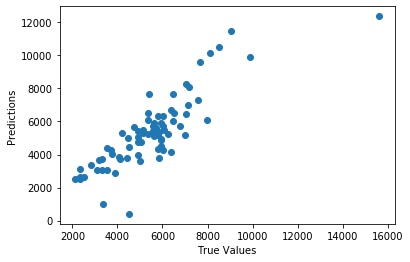

In [50]:
# correlation between true and predicted calories
import matplotlib.pyplot as plt
import seaborn as sns

# plt.scatter(y_cal_test['calPerServing'],predictions)
fig = plt.scatter(y_cal_test['totalCal'],predictions)
fig.axes.set_xlabel('True Values')
fig.axes.set_ylabel('Predictions')

In [53]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(predictions,y_cal_test['totalCal'])

In [78]:
print('Slope: ', round(slope,2))
print('Intercept: ', round(intercept))
print('Coefficient of Determinant: ', round(r_value**2,2))
print('p-value: ', p_value)
print('Standard Error: ', round(std_err,2)) # standard error of the slope

Slope:  0.78
Intercept:  1316.0
Coefficient of Determinant:  0.72
p-value:  1.35199918420095e-21
Standard Error:  0.06


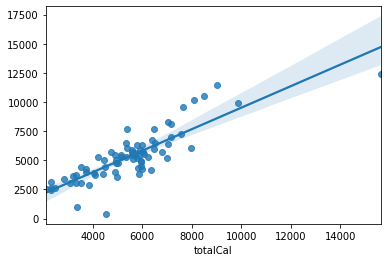

In [79]:
sns.regplot(y_cal_test['totalCal'],predictions)

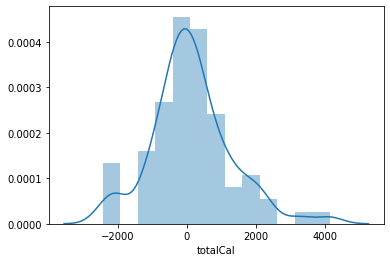

In [30]:
# residual plot - if normally distributed, then this model is good. otherwise, should not use linear prediction model
sns.distplot(y_cal_test['totalCal']-predictions)

In [31]:
from sklearn import metrics
print(round(np.sqrt(metrics.mean_absolute_error(y_cal_test['calPerServing'],predictions)),2))
metrics.r2_score(y_cal_test['calPerServing'],predictions) # this r2 is not representative of a normal r2 since it can be negative

71.7


-2803.1876380821104

#### Save BoW and TF-IDF vectorization as csv - doesn't work

In [ ]:
bow_transformer.to_csv('bow_transformer.csv')
ingredient_bow.to_csv('ingredient_bow.csv')
ingredient_tfidf.to_csv('ingredient_tfidf.csv')

# Logistic Regression

In [712]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
from sklearn.feature_extraction.text import TfidfTransformer # TF-IDF
from sklearn.linear_model import LogisticRegression
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
#    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression(max_iter=6000)),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline.fit(X_train['ingredient'],y_train) # Fit Model using training data
predictions = pipeline.predict(X_test['ingredient']) # Predict using test data
print(predictions)

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(predictions,y_test))

/Users/jinnysun/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0]
              precision    recall  f1-score   support

           0       0.71      0.56      0.63        54
           1       0.25      0.40      0.31        20

    accuracy                           0.51        74
   macro avg       0.48      0.48      0.47        74
weighted avg       0.59      0.51      0.54        74



In [ ]:
X_train['ingredient']

In [ ]:
y_test

In [729]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
from sklearn.feature_extraction.text import TfidfTransformer # TF-IDF
from sklearn.linear_model import LogisticRegression
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline.fit(X_train['ingredient'],y_train) # Fit Model using training data
predictions = pipeline.predict(X_test['ingredient']) # Predict using test data
print(predictions)

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(predictions,y_test))

[0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.93      0.57      0.71        68
           1       0.09      0.50      0.16         6

    accuracy                           0.57        74
   macro avg       0.51      0.54      0.43        74
weighted avg       0.86      0.57      0.66        74



# Linear Regression

### Pipeline

In [711]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
from sklearn.feature_extraction.text import TfidfTransformer # TF-IDF
from sklearn.linear_model import LinearRegression
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
#    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LinearRegression(fit_intercept=False)),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline.fit(X_train['ingredient'],y_cal_train['totalCal']) # Fit Model using training data
predictions = pipeline.predict(X_test['ingredient']) # Predict using test data
print(predictions)

[ 4460.14336385  6259.2458681   7540.86394265 13709.50237719
  5894.21071303  3796.03745614  4065.21123286  4937.99111231
  3229.47918039  8419.52630108  5823.81493979  4701.6665394
  4345.33420086  5254.48555263  7021.46056763 12425.65869853
  5682.32524019  6437.77086683  4390.13748885  3989.26107891
  5277.64958244 13489.40492992  4245.33174828 28123.96372229
  6290.60660903  1880.85269603  5459.73097436  5342.43339379
  7722.82542999 10693.97037895  6229.02859281  1622.00737375
  1650.74052531 11295.94290508  4970.48055804  2979.44176884
   916.94551843  6786.65950524  5944.44893653  7894.87354109
  4890.13537182  2257.27629667  7812.50280726  2435.81150066
  4538.71684219 11822.7581744   3120.57714907  5326.2323409
  6033.31509401  5792.96476106  5329.48640926 10718.98372355
  3620.85571699  3658.43501083  5619.86336703  3940.82443756
  5832.29188541  3669.35313687  2384.94240253  5849.33818873
  4538.19360146  5139.39307792  3710.92470326  6555.00533902
  3501.31221746  5953.5711

In [84]:
train_ingredient_bow

NameError: name 'train_ingredient_bow' is not defined

In [85]:
len(X_train)

2053

In [86]:
len(lm.coef_)

NameError: name 'lm' is not defined

### Separate steps

In [713]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
# from sklearn.feature_extraction.text import TfidfTransformer # TF-IDF
from sklearn.linear_model import LinearRegression

bow_transformer = CountVectorizer(analyzer=text_process).fit(X_train['ingredient'])
print(len(bow_transformer.vocabulary_)) # Print total number of vocab words

train_ingredient_bow = bow_transformer.fit_transform(X_train['ingredient'])
lm = LinearRegression(fit_intercept=False)
lm.fit(train_ingredient_bow,y_cal_train['totalCal'])
#lm.fit(train_ingredient_bow,y_cal_train['calPerServing'])

156


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [714]:
print(lm.intercept_)

1073.4295645691227


In [715]:
lm.coef_

array([ 5.18029008e-01,  7.66269485e+00,  1.09206200e-01, -3.10703881e+01,
       -1.01665754e+01,  1.08391393e+00, -9.16359655e+00,  2.89866309e+00,
       -4.52483748e+00, -5.31770801e+00,  7.34753629e+00,  9.83153990e+01,
        1.16655661e+01,  2.41392660e+00,  1.19645866e+02, -8.68709239e+01,
       -3.54787064e+00,  4.91268488e+00,  5.36977109e+00,  1.57412588e+00,
        7.40148636e+00,  1.11678337e+01,  2.86803865e+00, -4.74103106e-01,
       -2.60925392e+00,  1.10159540e+02,  1.06044218e+02,  2.26613263e+00,
        2.21663867e-02,  2.98846995e-01,  2.05494829e+00,  4.06859591e+00,
        1.48088060e-02,  4.90252898e+00,  1.52108051e+00,  1.69089073e+01,
        1.94138876e+00,  1.52455030e+01,  1.06586426e+01, -5.91880403e+01,
       -1.97859072e+01,  5.95937751e+00, -4.79279800e-01,  4.38992138e+00,
       -1.97478902e+01,  8.93830797e+00, -1.71037633e+00,  2.57999800e+00,
        1.87883343e+01, -5.21363169e+01, -1.33346813e+02,  7.11266698e-01,
        5.93160156e-01,  

In [716]:
coeff_words = pd.DataFrame(lm.coef_,bow_transformer.get_feature_names(), columns=['Coeff'])

In [728]:
coeff_words.sort_values('Coeff')

,Coeff
orange,-257.072070
teapoonshortening,-237.550164
coloring,-133.346813
mace,-96.939512
brandy,-86.870924
...,...
bourbon,119.645866
whippingcream,126.554843
espresso,127.253062
soda,159.959940


In [725]:
coeff_words.loc[['sugar','flour','butter','salt','chocolate']]

,Coeff
sugar,2.889723
flour,-0.318211
butter,4.912685
salt,29.535524
chocolate,4.068596


In [178]:
# test_recipe = 'pasta chicken butter'
test_recipe = X_test['ingredient'].loc[9714]
test_ingredient_bow = bow_transformer.transform([test_recipe])

In [185]:
test_ingredient_bow = bow_transformer.transform(X_test['ingredient'])

In [186]:
predictions = lm.predict(test_ingredient_bow)
predictions

array([ 4041.33491138,  3879.91614655,  5074.54029848,  6520.55044667,
        5123.65815893,  3980.30308321,  4127.30310534,  4134.776449  ,
        3658.14214164,  4103.49600595,  3043.51195605,  3585.1848169 ,
        5145.13992629,  4670.15057689,  4491.34573226,  4407.44024882,
        4767.03113887,  5733.62078158,  4242.94323864,  3802.53052388,
        4846.39121185,  3823.1811052 ,  4985.67598545,  4680.74436133,
        6151.88329977,  3448.79860642,  2989.88714073,  3411.51409026,
        4756.63200861,  3325.11967594,  3480.887153  ,  4243.77562462,
        4791.57201378,  3706.57276195,  5501.98976013,  3706.57276195,
        4720.70641083,  4836.09449757,  4727.03091697,  3361.42181364,
        5744.44848523,  4879.76272297,  4410.82193864,  7310.45340977,
        4360.28163072,  2858.13234365,  5312.18373619,  6333.64835288,
        6587.20992604,  5419.2459266 ,  5370.40249126,  3601.72826744,
        3855.01634975,  4925.11825878,  3977.85613409,  5055.67630051,
      

In [180]:
y_cal_test.loc[9714]

totalCal                      6996
calPerServing                  583
name             Turtles® Brownies
label                            1
Name: 9714, dtype: object

In [ ]:
# correlation between true and predicted calories
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(y_cal_test['calPerServing'],predictions)
# plt.scatter(y_cal_test['totalCal'],predictions)

In [ ]:
# residual plot - if normally distributed, then this model is good. otherwise, should not use linear prediction model
sns.distplot(y_cal_test['calPerServing']-predictions)

In [ ]:
from sklearn import metrics
print(round(np.sqrt(metrics.mean_absolute_error(y_cal_test['calPerServing'],predictions)),2))
metrics.r2_score(y_cal_test['calPerServing'],predictions)

In [ ]:
predictions.conf_int(0.05)

In [164]:
from sklearn.ensemble import GradientBoostingRegressor
# Set lower and upper quantile
LOWER_ALPHA = 0.1
UPPER_ALPHA = 0.9
# Create separate models for lower, median, and upper quantile values
lower_model = GradientBoostingRegressor(loss="quantile", alpha=LOWER_ALPHA)
mid_model = GradientBoostingRegressor(loss="ls")
upper_model = GradientBoostingRegressor(loss="quantile", alpha=UPPER_ALPHA)
# Fit models
lower_model.fit(X_train, y_train)
mid_model.fit(X_train, y_train)
upper_model.fit(X_train, y_train)
# Record actual values on test set
predictions = pd.DataFrame(y_test)
# Predict
predictions['lower'] = lower_model.predict(X_test)
predictions['mid'] = mid_model.predict(X_test)
predictions['upper'] = upper_model.predict(X_test)

# Naive Bayes

bag of words gives good precision but very bad recall

TF-IDF is assigning all recipes to one label, so recall=0.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
from sklearn.feature_extraction.text import TfidfTransformer # TF-IDF
from sklearn.naive_bayes import MultinomialNB # Naive Bayes Model
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
#    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline.fit(X_train['ingredient'],y_train) # Fit Model using training data
predictions = pipeline.predict(X_test['ingredient']) # Predict using test data
print(predictions)

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(predictions,y_test))

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
from sklearn.feature_extraction.text import TfidfTransformer # TF-IDF
from sklearn.naive_bayes import MultinomialNB # Naive Bayes Model
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline.fit(X_train['ingredient'],y_train) # Fit Model using training data
predictions = pipeline.predict(X_test['ingredient']) # Predict using test data
print(predictions)

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(predictions,y_test))

# Decision tree

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
from sklearn.feature_extraction.text import TfidfTransformer # TF-IDF
from sklearn.tree import DecisionTreeClassifier
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
#    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', DecisionTreeClassifier()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline.fit(X_train['ingredient'],y_train) # Fit Model using training data
predictions = pipeline.predict(X_test['ingredient']) # Predict using test data
print(predictions)

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(predictions,y_test))

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
from sklearn.feature_extraction.text import TfidfTransformer # TF-IDF
from sklearn.tree import DecisionTreeClassifier
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', DecisionTreeClassifier()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline.fit(X_train['ingredient'],y_train) # Fit Model using training data
predictions = pipeline.predict(X_test['ingredient']) # Predict using test data
print(predictions)

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(predictions,y_test))

# Random Forest 

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
from sklearn.feature_extraction.text import TfidfTransformer # TF-IDF
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
#    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier(n_estimators=200)),  # train on TF-IDF vectors w/ Naive Bayes classifier
])
    
pipeline.fit(X_train['ingredient'],y_train) # Fit Model using training data
predictions = pipeline.predict(X_test['ingredient']) # Predict using test data
print(predictions)

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(predictions,y_test))

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
from sklearn.feature_extraction.text import TfidfTransformer # TF-IDF
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier(n_estimators=200)),  # train on TF-IDF vectors w/ Naive Bayes classifier
])
    
pipeline.fit(X_train['ingredient'],y_train) # Fit Model using training data
predictions = pipeline.predict(X_test['ingredient']) # Predict using test data
print(predictions)

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(predictions,y_test))

# Note to self:

ML priority
* Priority is to to TF-IDF on the list of words.
* Then, add the other features (quantity, label) before doing the machine learning.
* Then, do machine learning.

Additional features
* Make "total calories" as a feature (calPerServing * servings)
* Remove/Tag certain word classes

# Clean text -  work in progress ...

1) For ingredients that got replaced with the "unit"value, need to replace the "unit" value as unit.
if ingredient[row]=nan, then ingredient[row]=unit[row], and unit[row]='unit'
* DON'T NEED TO DO THIS ANYMORE

2) Remove plural words using stemmer instead of wnl.lemmatize (ex. lammantize function doesnt change children to child)

3) Fix parse_text to improve removal of non-word punctuation


# Data visualization

In [718]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

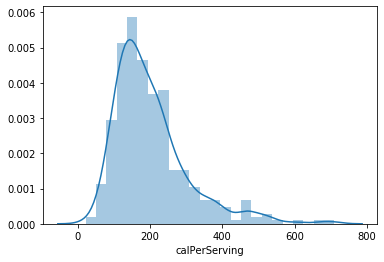

In [719]:
sns.distplot(df['calPerServing'])

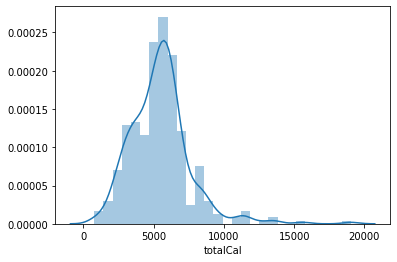

In [720]:
sns.distplot(df['totalCal'])

In [ ]:
sns.distplot(df[df['servings']==4]['calPerServing'])

In [ ]:
sns.distplot(df['num_ingredients'])
sns.distplot(df['servings'])

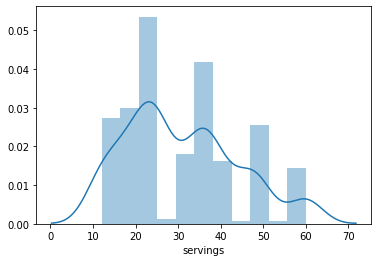

In [721]:
sns.distplot(df['servings'])

In [24]:
df[df['servings']==60]

,calPerServing,carbohydratesg,cholesterolmg,cookTime,directions,ingredients,name,nutrition,prepTime,proteing,...,totalTime,recipeDirection,recipeIngredient,servings,sodiummg,totalFatg,url,recipe_key,num_ingredients,label
5,141,141 calories; 7.7 g total fat; ...,15,8 mins,1. Preheat oven to 375 degrees F (190 degrees ...,"1 cup butter, softened, 1 cup white sugar, 1 c...",Urban Legend Chocolate Chip Cookies,141 calories; 7.7 g total fat; ...,15 mins,7.7,...,23 mins,Preheat oven to 375 degrees F (190 degrees C)....,"1 cup butter, softened; 1 cup white sugar; 1 c...",60,141 calories; 7.7 g total fat; ...,141 calories; 7.7 g total fat; ...,https://www.allrecipes.com/recipe/9804/urban-l...,9804,13,0
6,228,228 calories; 12.4 g total fat; ...,29,12 mins,1. Preheat the oven to 350 degrees F (175 degr...,"2 cups butter, 2 cups white sugar, 2 cups pack...",Wilderness Place Lodge Cookies,228 calories; 12.4 g total fat; ...,20 mins,12.4,...,32 mins,Preheat the oven to 350 degrees F (175 degrees...,2 cups butter; 2 cups white sugar; 2 cups pack...,60,228 calories; 12.4 g total fat; ...,228 calories; 12.4 g total fat; ...,https://www.allrecipes.com/recipe/53211/wilder...,53211,13,1
33,95,95 calories; 4.3 g total fat; ...,14,10 mins,1. Preheat oven to 350 degrees F (175 degrees ...,"2 cups all-purpose flour, 1 teaspoon baking po...",Cowboy Cookies III,95 calories; 4.3 g total fat; ...,15 mins,4.3,...,1 hr,Preheat oven to 350 degrees F (175 degrees C)....,2 cups all-purpose flour; 1 teaspoon baking po...,60,95 calories; 4.3 g total fat; ...,95 calories; 4.3 g total fat; ...,https://www.allrecipes.com/recipe/19213/cowboy...,19213,11,0
63,135,135 calories; 6.7 g total fat; ...,14,10 mins,1. Preheat oven to 350 degrees F (175 degrees ...,"1 ½ cups all-purpose flour, 1 ¼ teaspoons baki...",A to Z Everything-but-the-Kitchen-Sink Chocola...,135 calories; 6.7 g total fat; ...,30 mins,6.7,...,1 hr 10 mins,Preheat oven to 350 degrees F (175 degrees C)....,1 1/2 cups all-purpose flour; 11/4 teaspoons b...,60,135 calories; 6.7 g total fat; ...,135 calories; 6.7 g total fat; ...,https://www.allrecipes.com/recipe/26104/a-to-z...,26104,18,0
86,142,142 calories; 7.1 g total fat; ...,14,12 mins,1. Preheat the oven to 375 degrees F (190 degr...,"1 cup butter, softened, 2 cups packed brown su...",Kitchen Sink Cookies,142 calories; 7.1 g total fat; ...,15 mins,7.1,...,30 mins,Preheat the oven to 375 degrees F (190 degrees...,"1 cup butter, softened; 2 cups packed brown su...",60,142 calories; 7.1 g total fat; ...,142 calories; 7.1 g total fat; ...,https://www.allrecipes.com/recipe/25837/kitche...,25837,12,0
96,191,191 calories; 11.4 g total fat; ...,29,12 mins,1. Preheat the oven to 350 degrees F (175 degr...,"2 cups brown sugar, 1 cup white sugar, 2 cups ...",Best Whole Wheat Chocolate Chippers,191 calories; 11.4 g total fat; ...,20 mins,11.4,...,32 mins,Preheat the oven to 350 degrees F (175 degrees...,2 cups brown sugar; 1 cup white sugar; 2 cups ...,60,191 calories; 11.4 g total fat; ...,191 calories; 11.4 g total fat; ...,https://www.allrecipes.com/recipe/77464/best-w...,77464,10,0
155,72,72 calories; 3.6 g total fat; ...,6,NaN,1. Preheat oven to 350 degrees F (175 degrees ...,1 (18.25 ounce) package chocolate chip cake mi...,Chocolate Chip Cake Mix Cookies,72 calories; 3.6 g total fat; ...,NaN,3.6,...,NaN,Preheat oven to 350 degrees F (175 degrees C)....,1 (18.25 ounce) package chocolate chip cake mi...,60,72 calories; 3.6 g total fat; ...,72 calories; 3.6 g total fat; ...,https://www.allrecipes.com/recipe/10982/chocol...,10982,6,0
165,133,133 calories; 7.7 g total fat; ...,16,10 mins,1. Preheat an oven to 375 degrees F (190 degre...,"2 cups all-purpose flour, ¾ cup unsweetened co...",Chocolate Pile-Up Cookies,133 calories; 7.7 g total fat; ...,15 mins,7.7,...,45 mins,Preheat an oven to 375 degrees F (190 degrees ...,2 cups all-purpose flour; 3/4 cup unsweetened ...,60,133 calories; 7.7 g total fat; ...,133 calories; 7.7 g total fat; ...,https://www.allre

In [13]:
df['servings'].unique()

array([ 12,  36,  18,  42,  60,  24,  48,  72,  40,  16,  84,  20,   6,
        30,  15,  32,  96, 100,   1,  54, 150,  50, 144,   4, 168, 131,
        10,  56,  65,  33,  17,  21,  28,  45])

In [ ]:
sns.regplot(x='num_ingredients', y='calPerServing', data=clean_df)

In [ ]:
sns.regplot(x='servings', y='calPerServing', data=clean_df)

In [ ]:
sns.regplot(x='servings', y='num_ingredients', data=clean_df)